# Column에 대한 설명
'festive_period' : 축제 기간  
'cost' : 총비용  
'target_a' : a 연령대가 많이 방문하는 축제 {'old' : 장년층, 'family' : 가족 연령대(아이 + 부모), 'youth' : 청년 }  
'non_festival_conc' : 비축제 기간 축제 개최 '행정동' 일 평균 외부 방문자 수 / 축제 개최 '시군구' 일 평균 외부 방문자 수
'non_local' : 이동통신 데이터 기반 축제 개최 행정동 일 평균 현지인 방문자 수  
'non_foreigner' : 이동통신 데이터 기반 축제 개최 행정동 일 평균 외부 방문자 수(외지인+외국인)
'month_a' : a 월
'~' : 해당 행정 도 or 특별시

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
data = pd.read_csv('../data/df_charac.csv')

data.drop(columns='index_y' ,inplace= True)

#이상치 처리 함수 정의
def iqr(df, columns):
    df_clipped = df.copy()
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        df_clipped[column] = df[column].clip(lower=lower, upper=upper)
        
    return df_clipped

# 한글 column명 영어로 변경
data.rename(columns={'축제기간(일)' : "festive_period"}, inplace=True)

# 축제 기간 nan 값 평균치로 채워넣기.
data['festive_period'].fillna(data['festive_period'].mean(), inplace=True)

#iqr
data = iqr(data, ['visitors'])

# str 데이터 one_hot_encoding으로 분리, month는 category에 속해서 굳이 안해도 되는데 1~12월이 숫자가 늘어난다고 방문자 수가 늘어나는 구조는 아니라서 one-hot으로 변경. 약간의 R2 상승을 봤음.
data = pd.get_dummies(data, columns=['target'], drop_first=False)
data = pd.get_dummies(data, columns=['month'], drop_first=False)
data = pd.get_dummies(data, columns=['도'], drop_first=False)

#column 명 정리
data.columns = ['Unnamed: 0', 'Festival', 'name_year', 'year', 'visitors', 'cost',
       'date', 'visit/cost', 'Fe_festival_conc', 'Fe_foreigner', 'Fe_local',
       'Fe_navi', 'Fe_tour_fee', 'non_festival_conc', 'non_foreigner',
       'non_local', 'non_navi', 'non_tour_fee', 'festive_period',
       'target_family', 'target_old', 'target_youth', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Gangwon','Gyeonggi',
                'Gyeongnam', 
                'Gyeongbuk', 
                'Gwangju', 
                'Daegu',
                'Daejeon', 
                'Busan',
                'Seoul', 
                'Sejong', 
                'Ulsan', 
                'Incheon', 
                'Jeonnam', 
                'Jeonbuk', 
                'Jeju', 
                'Chungnam', 
                'Chungbuk']

# train_test_split : target 은 visitors.
X = data[['festive_period',
          'cost', 
          'target_family', 
          'target_old', 
          'target_youth',
          'non_festival_conc',
          'non_local',
          'non_foreigner',
          'month_1', 
          'month_2',
          'month_3', 
          'month_4', 
          'month_5', 
          'month_6', 
          'month_7', 
          'month_8',
          'month_9', 
          'month_10', 
          'month_11', 
          'month_12',
          'Gangwon',
          'Gyeonggi',                
          'Gyeongnam',                 
          'Gyeongbuk',                 
          'Gwangju',                 
          'Daegu',                
          'Daejeon',                
          'Busan',                
          'Seoul',                 
          'Sejong',                 
          'Ulsan',                 
          'Incheon',                 
          'Jeonnam',                 
          'Jeonbuk',                 
          'Jeju',                 
          'Chungnam',                 
          'Chungbuk'
          ]]
Y = data['visitors']
X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.2, random_state=5)


C:\Users\Jongho\AppData\Local\Temp\ipykernel_15024\1346442463.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['festive_period'].fillna(data['festive_period'].mean(), inplace=True)


# 모델 평가 함수 evaluate_model

In [5]:
# 모델 평가 함수 제작. mse 와 R2score 사용. 모델마다 평가할때 evaluate_model로 평가.

from sklearn.metrics import mean_squared_error, r2_score

def evaluate_models(best_visitors, X_test, Y_test):
    # Visitors 모델 평가
    y_pred = best_visitors.predict(X_test)
    mse_visitors = mean_squared_error(Y_test, y_pred)
    r2_visitors = r2_score(Y_test, y_pred)


    # 결과 출력
    print(f"Visitors Model Performance:")
    print(f"  MSE: {mse_visitors}")
    print(f"  R²: {r2_visitors}")


# Feature importance 시각화 함수 정의

In [23]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Feature importance 시각화 함수
def feature_importance(model, feature, model_name):
    importance = model.feature_importances_
    idx = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[idx])
    plt.xticks(range(len(importance)), np.array(X.columns)[idx], rotation=90)
    plt.title(f"{model_name} Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()



# Learning_curve 시각화 함수 정의

In [35]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

cv = 5

def learning_curve_plot(model, X, Y, cv):
    # MSE 계산
    train_sizes, train_scores_mse, test_scores_mse = learning_curve(
        model, X, Y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    train_mse = np.mean(-train_scores_mse, axis=1)
    test_mse = np.mean(-test_scores_mse, axis=1)

    # R² 계산
    _, train_scores_r2, test_scores_r2 = learning_curve(
        model, X, Y, cv=cv, scoring='r2', n_jobs=-1)
    train_r2 = np.mean(train_scores_r2, axis=1)
    test_r2 = np.mean(test_scores_r2, axis=1)

    # 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 첫 번째 Y축: MSE
    ax1.plot(train_sizes, train_mse, label="Training MSE", marker='o', color='blue')
    ax1.plot(train_sizes, test_mse, label="Validation MSE", marker='o', color='orange')
    ax1.set_xlabel("Training Set Size")
    ax1.set_ylabel("MSE", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc="upper left")
    ax1.grid()

    # 두 번째 Y축: R²
    ax2 = ax1.twinx()  # 두 번째 Y축 공유
    ax2.plot(train_sizes, train_r2, label="Training R²", marker='x', color='green')
    ax2.plot(train_sizes, test_r2, label="Validation R²", marker='x', color='red')
    ax2.set_ylabel("R² Score", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc="upper right")
    
    plt.title(f'Learning Curve ({model_name}) with Dual Y-Axis')
    plt.show()





In [ ]:
#model = best_xx_visitors
#model_name = type(model).__name__

#feature_importance(model, X.columns, model_name)
#learning_curve_plot(model, X, Y, cv)

# RandomForestRegressor

In [8]:
# train_test 결과값.

from sklearn.ensemble import RandomForestRegressor

def train_models(X_train, Y_train):
    rf_visitors = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_visitors.fit(X_train, Y_train)

    return rf_visitors
rf_visitors = train_models(X_train, Y_train)

evaluate_models(rf_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 2353736549.5034213
  R²: 0.6307875684537696


In [9]:
# 그리드 서치를 통한 하이퍼 파라미터 조정
from sklearn.model_selection import GridSearchCV

def tune_rf(X_train, Y_train):
    param_grid_rf = {
        'n_estimators': np.arange(40, 60, 10),
        'max_depth': [16, 17 ,18],
        'min_samples_split':  [3,4,5]}

    rf_visitors = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search_rf_visitors = GridSearchCV(estimator=rf_visitors, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
    grid_search_rf_visitors.fit(X_train, Y_train)
    
    print(f"Best visitors RF : {grid_search_rf_visitors.best_params_}")

    return grid_search_rf_visitors.best_estimator_


best_rf_visitors = tune_rf(X_train, Y_train)


Best visitors RF : {'max_depth': 18, 'min_samples_split': 3, 'n_estimators': 50}


In [10]:
# RandomForest 모델 평가
evaluate_models(best_rf_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 2456103963.7405896
  R²: 0.6147299846389713


In [11]:
# K Fold와 cv score 추가로 도입.
# grid search에서 이미 cv = 5를 적용하였지만, 각 fold별 변동폭이 커서, 전체 데이터 셋으로 체크.

from sklearn.model_selection import KFold, cross_val_score


kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_rf_visitors, X, Y, cv=kf)

print("Fold별 R2 score:", cv_scores)
print("평균 R2 score:", np.mean(cv_scores))


Fold별 R2 score: [0.45855016 0.71387008 0.59560164 0.44997592 0.67518227 0.50506883
 0.70481614 0.63456602 0.39513638 0.58708823]
평균 R2 score: 0.5719855659706026


# RandomForest 시각화

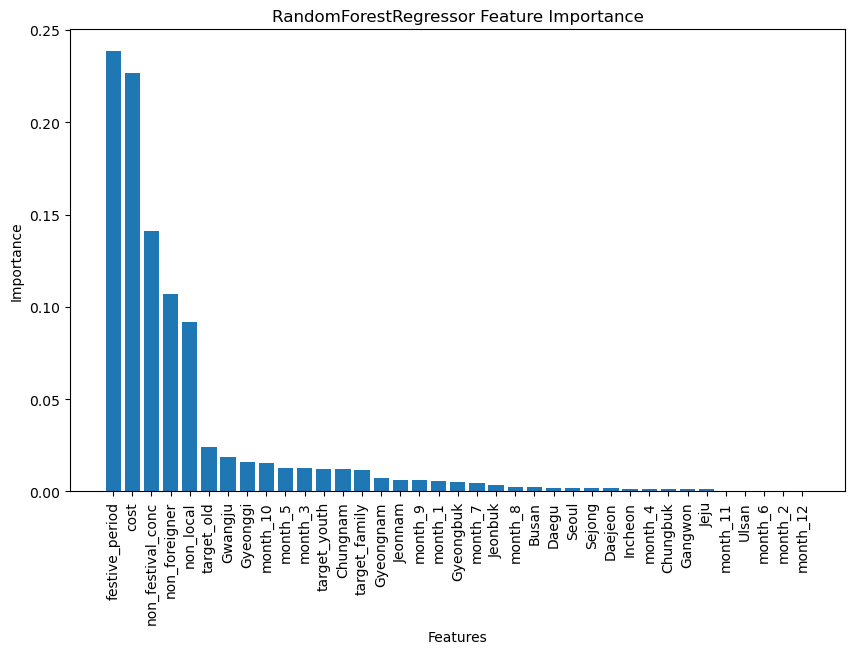

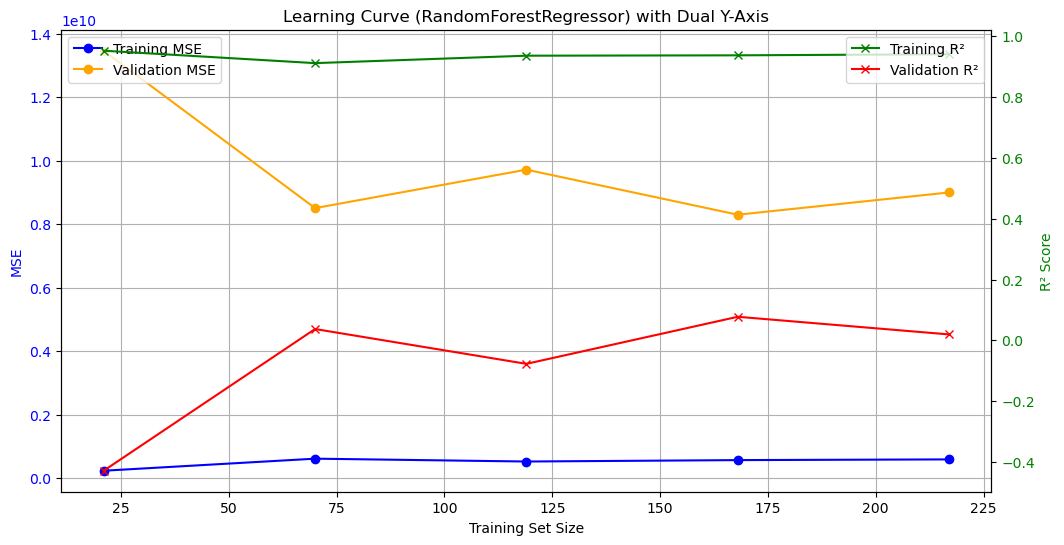

In [37]:
model = best_rf_visitors
model_name = type(model).__name__

feature_importance(model, X.columns, model_name)
learning_curve_plot(model, X, Y, cv)

# Xgboost

In [12]:
# train test 기본 결과값.
import xgboost as xgb

def train_xgboost(X_train, Y_train):
    
    xgb_visitors = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_visitors.fit(X_train, Y_train)

    xgb_vicost = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_vicost.fit(X_train, Y_train)
    
    return xgb_visitors

xgb_visitors = train_xgboost(X_train, Y_train)

evaluate_models(xgb_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 2227631920.3158746
  R²: 0.6505686254209959


In [13]:
# 그리드 서치로 하이퍼 파라미터 조정
from sklearn.model_selection import GridSearchCV
def tune_xgb(X_train, Y_train):
    param_grid_xgb = {
        'n_estimators': np.arange(90,110,10),
        'max_depth': [7,8, 9,10],
        'learning_rate': [0.03],
        'subsample': [0.75,0.8,0.85],
        'colsample_bytree': np.arange(0.5, 0.7, 0.1)}

    xgb_visitors = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    grid_search_xgb_visitors = GridSearchCV(estimator=xgb_visitors, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
    grid_search_xgb_visitors.fit(X_train, Y_train)
    
    print(f"Best xgb visitors: {grid_search_xgb_visitors.best_params_}")

    return grid_search_xgb_visitors.best_estimator_

best_xgb_visitors = tune_xgb(X_train, Y_train)

Best xgb visitors: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.85}


In [14]:
# 모델 평가 함수로 조정된 sgboost 결과 확인.
evaluate_models(best_xgb_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 2562179620.0701804
  R²: 0.5980907175937393


In [15]:
# K Fold와 cv score 추가로 도입.
# grid search에서 이미 cv = 5를 적용하였지만, 각 fold별 변동폭이 커서, 전체 데이터 셋으로 체크.

from sklearn.model_selection import KFold, cross_val_score


kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_xgb_visitors, X, Y, cv=kf)

print("Fold별 R2 score:", cv_scores)
print("평균 R2 score:", np.mean(cv_scores))


Fold별 R2 score: [0.52454952 0.66806852 0.63492389 0.4865923  0.665989   0.61334148
 0.73142431 0.63260805 0.39584553 0.6459998 ]
평균 R2 score: 0.5999342398267046


# XGBoost 시각화

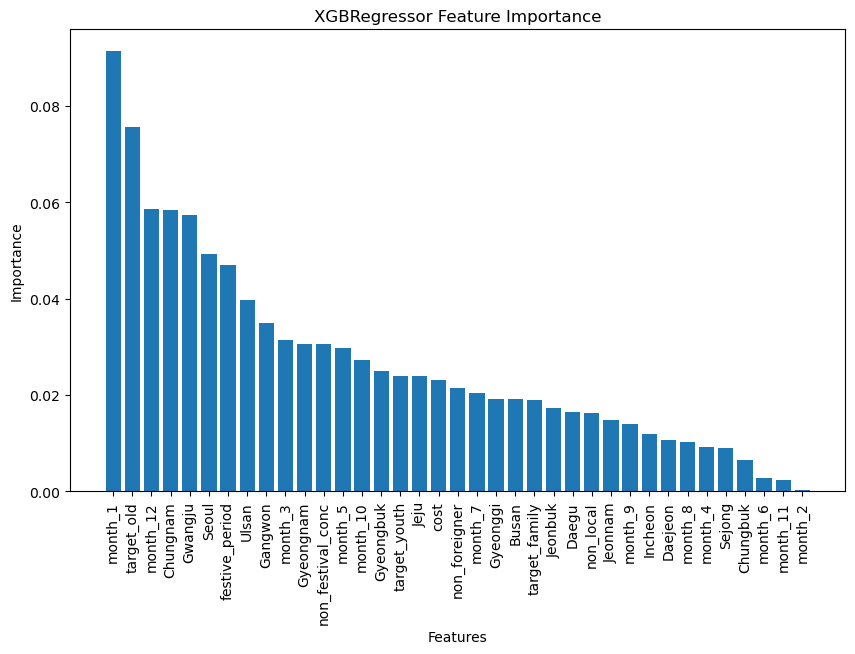

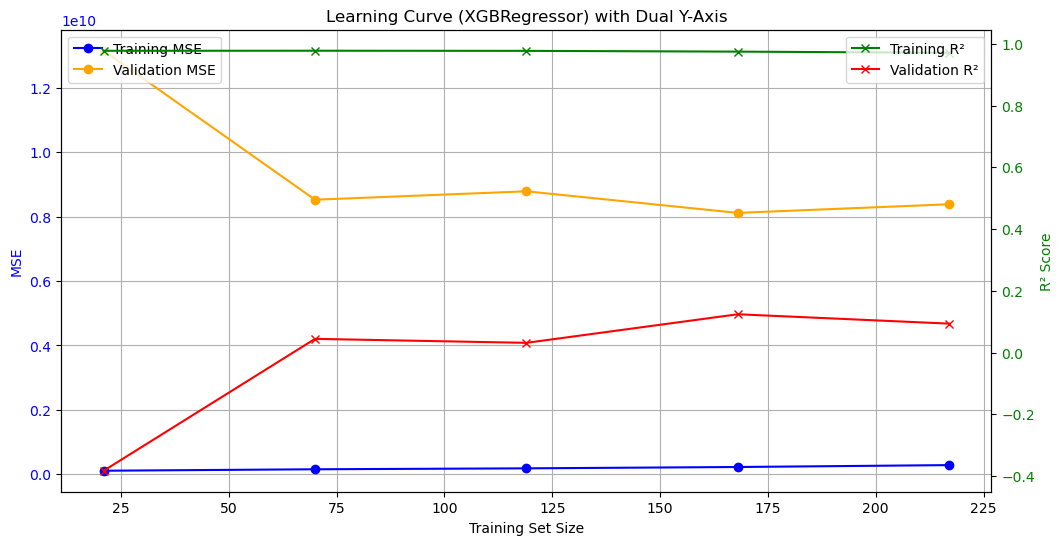

In [38]:
model = best_xgb_visitors
model_name = type(model).__name__

feature_importance(model, X.columns, model_name)
learning_curve_plot(model, X, Y, cv)

# ====================

# GradientBoostingRegressor -- 최종 선정

In [16]:
#기본 GradientBoosting

from sklearn.ensemble import GradientBoostingRegressor

def train_gradient_boosting(X_train, Y_train):
    gb_visitors = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_visitors.fit(X_train, Y_train)

    return gb_visitors

gb_visitors = train_gradient_boosting(X_train, Y_train)

evaluate_models(gb_visitors, X_test, Y_test)


Visitors Model Performance:
  MSE: 2328691116.999703
  R²: 0.634716251566489


In [17]:
# 그리드 서치로 하이퍼 파라미터 검정
from sklearn.model_selection import GridSearchCV
def tune_gb(X_train, Y_train):
    param_grid_gb = {
        'n_estimators': [190,200,210],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.04, 0.02, 0.03],
        'subsample': [0.7, 0.75, 0.8]}
    
    gb_visitors = GradientBoostingRegressor(random_state=42)
    grid_search_gb_visitors = GridSearchCV(estimator=gb_visitors, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
    grid_search_gb_visitors.fit(X_train, Y_train)

    print(f"Best gb visitors: {grid_search_gb_visitors.best_params_}")

    return grid_search_gb_visitors.best_estimator_

best_gb_visitors = tune_gb(X_train, Y_train)


Best gb visitors: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 210, 'subsample': 0.7}


In [18]:
# 평가함수로 모델 체크.
evaluate_models(best_gb_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 2286369554.6735315
  R²: 0.6413549074248


In [19]:
# K Fold와 cv score 추가로 도입.
# grid search에서 이미 cv = 5를 적용하였지만, 각 fold별 변동폭이 커서, 전체 데이터 셋으로 한번 더 체크.

from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_gb_visitors, X, Y, cv=kf)

print("Fold별 R2 score:", cv_scores)
print("평균 R2 score:", np.mean(cv_scores))


Fold별 R2 score: [0.53076437 0.71929564 0.7116982  0.46441509 0.67231274 0.56519664
 0.78881469 0.72028834 0.48794763 0.66145688]
평균 R2 score: 0.6322190225724836


In [49]:
type(Y)

pandas.core.series.Series

# LOO 검증.

In [52]:
from sklearn.model_selection import LeaveOneOut

def loo_validation(X, Y, model):
    loo = LeaveOneOut()
    mse_scores = []
    r2_scores = []

    for train_index, test_index in loo.split(X):
        # Train/Test split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # 모델 학습 및 예측
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 성능 측정
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    # 결과 요약
    results = {
        'mean_mse': np.mean(mse_scores)
    }
    return results

results = loo_validation(X, Y, best_gb_visitors)
print("LOO Validation Results:")
print(f"Mean MSE: {results['mean_mse']}")


LOO Validation Results:
Mean MSE: 3603077914.1714163


# GradientBoosting 시각화

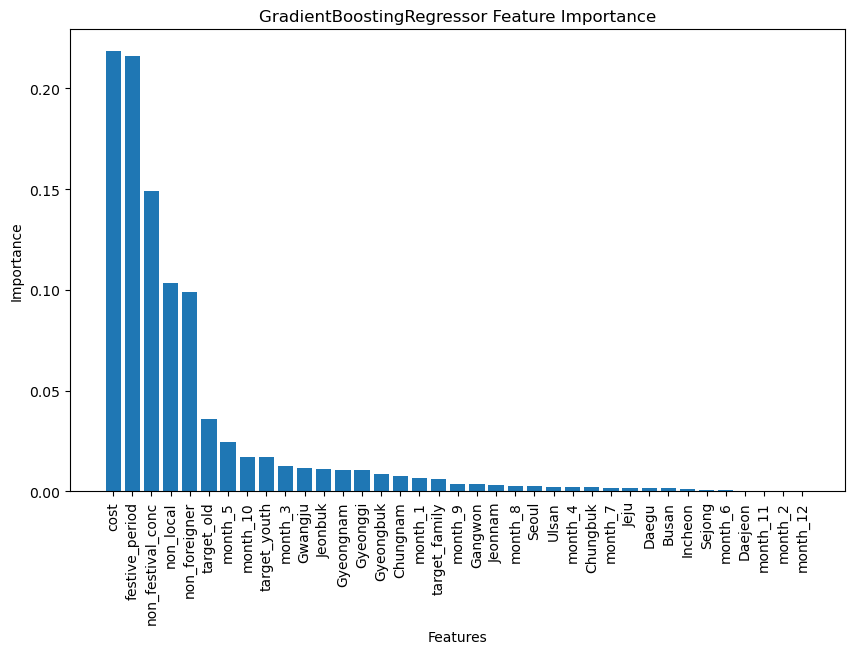

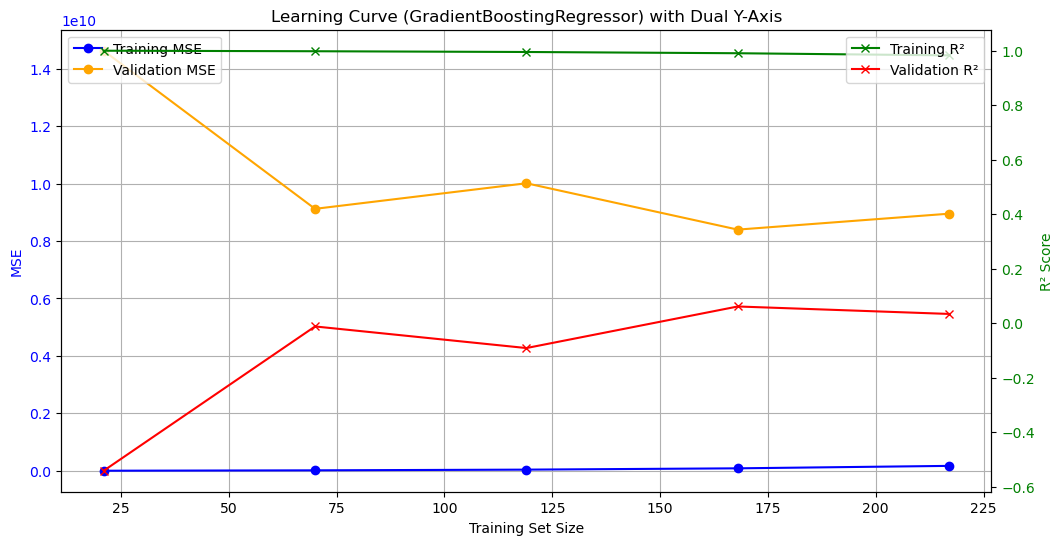

In [39]:
model = best_gb_visitors
model_name = type(model).__name__
feature_importance(model, X.columns, model_name)
learning_curve_plot(model, X, Y, cv)

# train test split만
Visitors Model Performance:
  MSE: 2328691116.999703
  R²: 0.634716251566489
  
# gridsearch 이후.
Visitors Model Performance:
  MSE: 2286369554.6735315
  R²: 0.6413549074248
  
# K Fold로 다르게 쪼갰을 때도 같은지 검정.
Fold별 R2 score: [0.53076437 0.71929564 0.7116982  0.46441509 0.67231274 0.56519664
 0.78881469 0.72028834 0.48794763 0.66145688]
 평균 R2 score: 0.6322190225724836  

# LOO 검증으로 좀더 자세하게 테스트
LOO Validation Results:
Mean MSE: 3603077914.1714163



# ====================
# RANSACRegressor -- 망함.

In [20]:
# 기본 train test 값
from sklearn.linear_model import RANSACRegressor

def train_ransac(X_train, Y_train):
    ransac_visitors = RANSACRegressor(random_state=42)
    ransac_visitors.fit(X_train, Y_train)
    
    return ransac_visitors

ransac_visitors = train_ransac(X_train, Y_train)

evaluate_models(ransac_visitors, X_test, Y_test)
    

Visitors Model Performance:
  MSE: 6843246960.712327
  R²: -0.0734471751177932


In [ ]:
# 그리드 서치로 튜닝

def tune_rs(X_train, Y_train):
    param_grid_ransac = {
        'min_samples': [0.7, 0.8, 0.9],
        'residual_threshold': [5, 10, 20],
        'max_trials': [50, 100, 150],
    }
    ransac_visitors = RANSACRegressor(random_state=42)
    grid_search_ransac_visitors = GridSearchCV(estimator=ransac_visitors, param_grid=param_grid_ransac, cv=3, scoring='neg_mean_squared_error')
    grid_search_ransac_visitors.fit(X_train, Y_train)

    print(f"Best rs visitors: {grid_search_ransac_visitors.best_params_}")

    return grid_search_ransac_visitors.best_estimator_

best_rs_visitors = tune_rs(X_train, Y_train)

Best rs visitors: {'max_trials': 100, 'min_samples': 0.7, 'residual_threshold': 5}


In [42]:
#평가 함수로 평가
evaluate_models(best_rs_visitors, X_test, Y_test)

Visitors Model Performance:
  MSE: 6051818889.680015
  R²: 0.05069801970506438


# RANSAC 시각화
feature importance는 RANSAC이 트리구조가 아니라서 없음.

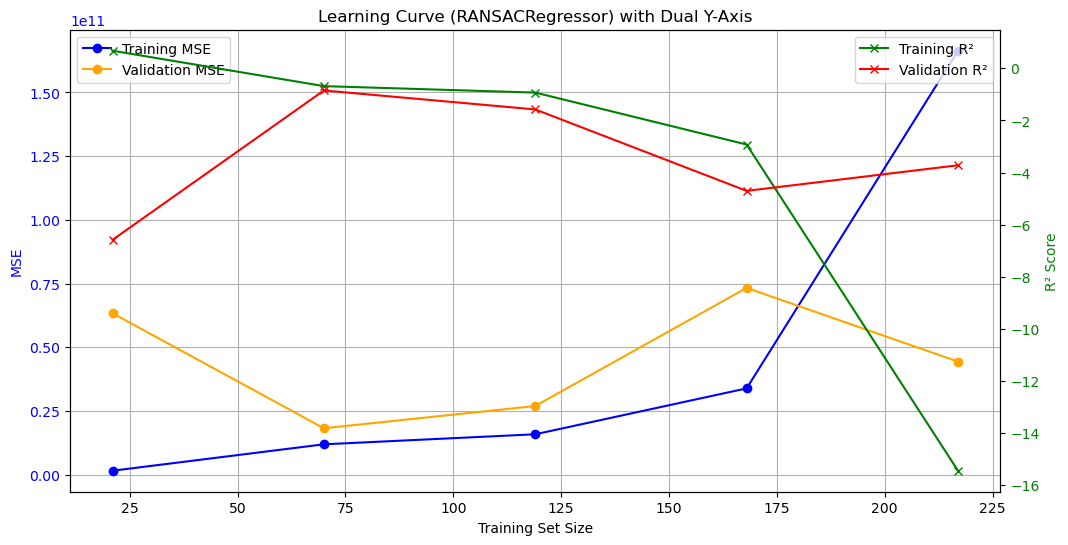

In [45]:
model = best_rs_visitors
model_name = type(model).__name__

learning_curve_plot(model, X, Y, cv)

In [53]:
X.columns

Index(['festive_period', 'cost', 'target_family', 'target_old', 'target_youth',
       'non_festival_conc', 'non_local', 'non_foreigner', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Gangwon', 'Gyeonggi',
       'Gyeongnam', 'Gyeongbuk', 'Gwangju', 'Daegu', 'Daejeon', 'Busan',
       'Seoul', 'Sejong', 'Ulsan', 'Incheon', 'Jeonnam', 'Jeonbuk', 'Jeju',
       'Chungnam', 'Chungbuk'],
      dtype='object')

# gb 예측시 사용할 함수 정의

In [ ]:
import pandas as pd

# 입력 데이터 매핑용
all_columns = X.columns

# 입력 데이터 매핑용 컬럼 이름
input_columns = ['cost', 'festive_period', 'non_local', 'non_foreigner', 'non_festival_conc', 'month', 'target', 'region']

def festival_list_to_dict(festival_list, festival_name):
    data = dict(zip(input_columns, festival_list))
    data['Festival_Name'] = festival_name
    return data

def prepare_festival_dataset(festival_data, festival_names):
    # 축제 데이터를 딕셔너리로 변환
    festival_dicts = [festival_list_to_dict(festival, name) for festival, name in zip(festival_data, festival_names)]
    
    # 결과를 저장할 리스트
    dataset = []

    for festival in festival_dicts:
        # 기본 값이 모두 0인 데이터 생성
        row = {col: 0 for col in all_columns}  # all_columns는 모델 학습 시 사용된 열만 포함
        
        # 고정 컬럼 값 설정
        for key in ['cost', 'festive_period', 'non_local', 'non_foreigner', 'non_festival_conc']:
            if key in festival:
                row[key] = festival[key]
        
        # month 원-핫 인코딩
        if 'month' in festival:
            month_col = f"month_{festival['month']}"
            if month_col in row:
                row[month_col] = 1

        # target 원-핫 인코딩
        if 'target' in festival:
            target_col = f"target_{festival['target']}"
            if target_col in row:
                row[target_col] = 1

        # region 원-핫 인코딩
        if 'region' in festival:
            region_col = festival['region']
            if region_col in row:
                row[region_col] = 1

        # 축제 이름 추가 (결과 데이터프레임용)
        row['Festival_Name'] = festival['Festival_Name']

        # 완성된 행 추가
        dataset.append(row)
    
    # 데이터프레임으로 변환
    prepared_df = pd.DataFrame(dataset)  # all_columns에 Festival_Name 포함 X
    return prepared_df

def predict_festival_outcomes(model, festival_data, festival_names):
    # 데이터셋 준비
    prepared_data = prepare_festival_dataset(festival_data, festival_names)

    # 모델 입력 데이터 준비 (all_columns로 맞춤)
    input_data = prepared_data[all_columns]

    # 모델 예측 수행
    predictions = model.predict(input_data)

    # 결과 데이터프레임 생성
    result_df = pd.DataFrame({
        'Festival_Name': prepared_data['Festival_Name'],
        'Prediction': predictions
    })

    return result_df



       Festival_Name     Prediction
0  Gangyong Festival  122603.475011
1     Busan Festival  146183.400006


In [113]:
#input_columns = ['cost', 'festive_period', 'non_local', 'non_foreigner', 
#                 'non_festival_conc', 'month', 'target', 'region']

Gangyong_Festival = [825000000, 5, 0.5561146496815287, 0.3153189054071834, 0.4398701222635692, 10, 'old', 'Chungnam']
chungza = [949740970, 10, 0.1502364644, 0.1016054665, 0.2168729646, 2, 'old', 'Jeonnam']
mudFestival = [4578328000, 17, 0.746979523,0.3455248086,0.8373614469,'family', 'Chungnam']
arirang = [2200000000, 4, 0.8446749471, 0.2874386477, 0.6172523879, 'old', 'Gyeongnam']

festival_data = [Gangyong_Festival, chungza,mudFestival,arirang]
festival_names = ['Gangyong Festival', 'chungza','mudFestival','arirang']

# 모델 예측 수행
result = predict_festival_outcomes(best_gb_visitors, festival_data, festival_names)
# 2024년 실제 방문객 대입 이름 순에 맞춰서 기재
actual_values = [300000, 204000,1650000,410000]

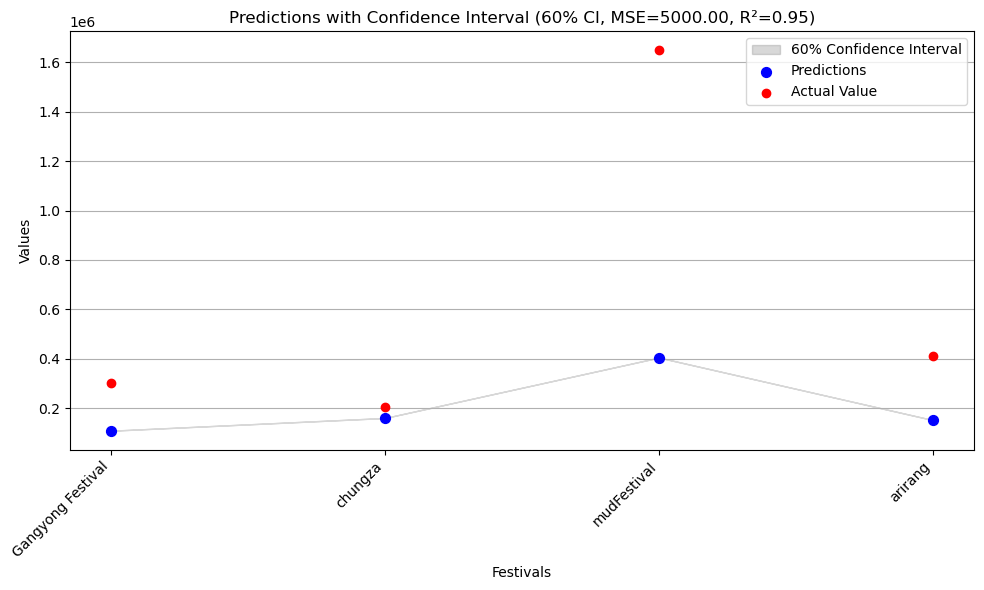

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mse : 2286369554.6735315
r2 : 0.6413549074248

def plot_predictions_with_confidence_area(data, mse, r2, actual_values, confidence_interval=0.95):
    predictions = data['Prediction']
    festival_names = data['Festival_Name']
    
    # 신뢰 구간 z-score 계산
    z_score = norm.ppf(0.5 + confidence_interval / 2)
    
    # MSE 기반 오차 범위 계산
    sigma = np.sqrt(mse)  # 표준편차 계산
    lower_bound = predictions - z_score * sigma  # 신뢰 하한
    upper_bound = predictions + z_score * sigma  # 신뢰 상한

    # 그래프 설정
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(festival_names))  # 축제명 위치

    # 신뢰 구간 면적
    plt.fill_between(x_positions, lower_bound, upper_bound, color='gray', alpha=0.3, label=f'{int(confidence_interval*100)}% Confidence Interval')
    
    # 예측값 점으로 표시
    plt.scatter(x_positions, predictions, color='blue', zorder=5, label='Predictions', s=50)
    
    # 실제 값 표시 (NaN 제외)
    if actual_values is not None:
        for i, actual in enumerate(actual_values):
            if not np.isnan(actual):  # NaN이 아닌 경우만 표시
                plt.scatter(i, actual, color='red', zorder=6, label='Actual Value' if i == 0 else "")  # 실제 값 (첫 번째 레이블만 표시)

    # x축 설정
    plt.xticks(x_positions, festival_names, rotation=45, ha='right')
    plt.xlabel("Festivals")
    plt.ylabel("Values")
    plt.title(f"Predictions with Confidence Interval ({int(confidence_interval * 100)}% CI, MSE={mse:.2f}, R²={r2:.2f})")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 그래프 출력 (60% 신뢰 구간)
plot_predictions_with_confidence_area(result, mse, r2, actual_values, confidence_interval=0.60)
